# 实战Kaggle比赛：预测房价

### 1. 下载和缓存数据集

这里我们实现几个函数来方便下载数据。 首先，我们建立字典DATA_HUB， 它可以将数据集名称的字符串映射到数据集相关的二元组上， 这个二元组包含数据集的url和验证文件完整性的sha-1密钥。 所有类似的数据集都托管在地址为DATA_URL的站点上。

In [110]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

下面的download函数用来下载数据集， 将数据集缓存在本地目录（默认情况下为../data）中， 并返回下载文件的名称。 如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配， 我们将使用缓存的文件，以避免重复的下载。

In [111]:
def download(name, cache_dir=os.path.join('..','data')):    #@save
    """下载一个DATA_HUB中的文件,返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(104876)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname    # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

我们还需实现两个实用函数： 一个将下载并解压缩一个zip或tar文件， 另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。

In [112]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

### 3. 访问和读取数据集

In [113]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [114]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

我们使用pandas分别加载包含训练数据和测试数据的两个CSV文件。

In [115]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

训练数据集包括1460个样本，每个样本80个特征和1个标签， 而测试数据集包含1459个样本，每个样本80个特征。

In [116]:
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

In [117]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


我们可以看到，在每个样本中，第一个特征是ID， 这有助于模型识别每个训练样本。 虽然这很方便，但它不携带任何用于预测的信息。 因此，在将数据提供给模型之前，我们将其从数据集中删除。

In [118]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

### 4. 数据预处理

标准化数据 + 零填充

In [119]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x:(x - x.mean()) / x.std()
)
# 在标准化数据之后，所有均值为0，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来，我们处理离散值。 这包括诸如“MSZoning”之类的特征。 我们用独热编码替换它们, 例如，“MSZoning”包含值“RL”和“Rm”。 我们将创建两个新的指示器特征“MSZoning_RL”和“MSZoning_RM”，其值为0或1。 根据独热编码，如果“MSZoning”的原始值为“RL”， 则：“MSZoning_RL”为1，“MSZoning_RM”为0。 pandas软件包会自动为我们实现这一点。

In [120]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

通过values属性，我们可以从pandas格式中提取NumPy格式，并将其转换为张量表示用于训练。

In [121]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data['SalePrice'].values.reshape(-1, 1), dtype=torch.float32)

### 5. 训练

首先，我们训练一个带有损失平方的线性模型。 如果一切顺利，线性模型将作为基线（baseline）模型， 让我们直观地知道最好的模型有超出简单的模型多少。

In [122]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

房价就像股票价格一样，我们关心的是相对数量，而不是绝对数量。 因此，我们更关心相对误差,而不是绝对误差。解决这个问题的一种方法是用价格预测的对数来衡量差异。

In [123]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

 Adam优化器的主要吸引力在于它对初始学习率不那么敏感。

In [124]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
      train_ls, test_ls = [], []
      train_iter = d2l.load_array((train_features, train_labels), batch_size, is_train=True)
      # 这里使用的是Adam优化算法
      optim = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
      for epoch in range(num_epochs):
            for X, y in train_iter:
                optim.zero_grad()
                l = loss(net(X), y)
                l.backward()
                optim.step()
            train_ls.append(log_rmse(net, train_features, train_labels))
            if test_labels is not None:
                  test_ls.append(log_rmse(net, test_features, test_labels))
      return train_ls, test_ls

### 6. K折交叉验证

In [125]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None

    idx = slice(i * fold_size, (i + 1) * fold_size)
    #method 1
    X_valid, y_valid = X[idx], y[idx]
    X_train = torch.cat([X[:i * fold_size], X[(i + 1) * fold_size:]], 0)
    y_train = torch.cat([y[:i * fold_size], y[(i + 1) * fold_size:]], 0)
    
    #method 2
    
    # for j in range(k):
    #     idx = slice(j * fold_size, (j + 1) * fold_size)
    #     X_part, y_part = X[idx], y[idx]
    #     if j == i:
    #         X_valid, y_valid = X_part, y_part
    #     elif X_train is None:
    #         X_train, y_train = X_part, y_part
    #     else:
    #         X_train = torch.cat([X_train, X_part], 0)
    #         y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

当我们在K折交叉验证中训练K次后，返回训练和验证误差的平均值。

In [126]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]  
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1},训练log rmse: {float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

### 7. 模型选择

折1,训练log rmse: 0.170843, 验证log rmse0.156792
折2,训练log rmse: 0.161942, 验证log rmse0.188123
折3,训练log rmse: 0.163696, 验证log rmse0.167839
折4,训练log rmse: 0.168014, 验证log rmse0.154619
折5,训练log rmse: 0.162280, 验证log rmse0.182612
5-折验证: 平均训练log rmse: 0.165355, 平均验证log rmse: 0.169997


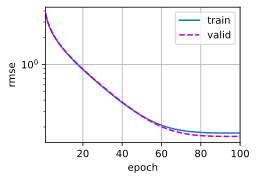

In [127]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                        weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

### 8. 提交你的Kaggle预测

In [128]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse:{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.flatten())
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

如果测试集上的预测与K倍交叉验证过程中的预测相似， 那就是时候把它们上传到Kaggle了。 下面的代码将生成一个名为submission.csv的文件。

训练log rmse:0.162625


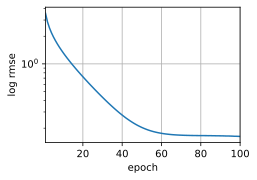

In [129]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)